# 1. Field shaping algorithm

The rotating magnetic setup consists of two identical rotating magnets with a certain distance between them. This  setup experiences magnetic field gradients parallel to the magnets when simple block magnets are used. These gradients generate unwanted forces, preventing the system from operating purely based on magnetic torque. While weaker magnets and minimizing the distance between opposing magnets can reduce these gradients, small residual gradients will persist.    

Several approaches can be used to further lower the magnetic gradient, including modifying magnetization strength, adjusting geometric properties, or changing the distance between opposing magnets. Among these, adjusting the distance between the opposing magnets is the most practical option, as it can be easily achieved by using multiple small magnets and 3D-printed slots to control their spacing. In contrast, altering geometric or magnetic properties is more challenging due to the limited availability of magnet shapes and the complexity of manufacturing custom magnet geometries.    

This notebook calculates the optimal magnetic setup for a specified magnetic field strength with the smallest possible gradient parallel to the magnets. This ensures that the rotating magnetic setup operates purely with torque without creating any unwanted gradients parallel to the magnets.

## Initializing functions

In [13]:
import numpy as np
import time
from numba import njit, prange
import numpy.polynomial.legendre as lg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

TOL = 1e-5 # Absolute error tolerance for numerial integration, change if needed

## Plot the magnetic grid and view the observation points.

In [14]:
#------------------------------------------------------------------
# Shows how all magnets are oriented and observation points in two views (XY and ZX). 
# Checks if the magnet orientation is fysicaly possible and if the observation points are correctly specified. 
# Observation points can only vary along the x, y, or z axis when the other two axes are set to a scalar.
#------------------------------------------------------------------
def plot_magnet_grid(a_total, a_one, n_x, b_total, b_one, n_y, h, zl, x_val, y_val, z_val):
    # Magnet orientations error checks.
    tol = 1e-9 # Tolerance for rounding errors
    if len(zl) != n_x:
        raise ValueError("The length of the zl array must equal the number of columns (n_x).")
    if n_x * a_one > a_total + tol:
        raise ValueError("n_x * a_one must be ≤ a_total to avoid overlapping magnets.")
    if n_y * b_one > b_total + tol:
        raise ValueError("n_y * b_one must be ≤ b_total to avoid overlapping magnets.")
    
    # Compute centers for the XY-plane.
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    
    # Process Observation Points.
    # Convert inputs to at least 1D arrays.
    x_val = np.atleast_1d(x_val)
    y_val = np.atleast_1d(y_val)
    z_val = np.atleast_1d(z_val)
    
    # Count how many observation inputs are arrays (size > 1).
    arr_count = sum(1 for arr in [x_val, y_val, z_val] if arr.size > 1)
    if arr_count > 1:
        raise ValueError("Observation points must be specified as either scalars or at most one array.")
    
    # Determine target size (if one array is provided, target_size > 1; otherwise target_size == 1)
    target_size = max(x_val.size, y_val.size, z_val.size)
    if target_size > 1:
        if x_val.size == 1:
            x_val = np.full(target_size, x_val[0])
        if y_val.size == 1:
            y_val = np.full(target_size, y_val[0])
        if z_val.size == 1:
            z_val = np.full(target_size, z_val[0])
    
    # Create Figure with Two Subplots.
    fig, (ax_xy, ax_zx) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    ax_xy.set_facecolor('white')
    ax_zx.set_facecolor('white')
    
    # --- Create XY plot ---
    # Plot the Magnet Grid in the XY-Plane.
    for row in range(n_y):
        for col in range(n_x):
            rect_x = x_centers[col] - a_one/2.0
            rect_y = y_centers[row] - b_one/2.0
            magnet_rect = Rectangle((rect_x, rect_y), a_one, b_one,
                                      edgecolor='black', facecolor='lightgrey', lw=2)
            ax_xy.add_patch(magnet_rect)
    
    # Plot observation points on the XY-plane.
    ax_xy.plot(x_val, y_val, 'ro', markersize=4, label='Obs Points')
    ax_xy.set_title('Magnet Grid in XY-Plane')
    ax_xy.set_xlabel('x (m)')
    ax_xy.set_ylabel('y (m)')
    ax_xy.set_xlim(-a_total/1.8, a_total/1.8)
    ax_xy.set_ylim(-b_total, b_total)
    ax_xy.set_aspect('equal', adjustable='box')
    ax_xy.grid(True)
    ax_xy.legend()
    
    # --- Create XZ plot ---
    # Plot the Magnet Grid in the ZX-Plane (with Mirrored Arrays)
    for col in range(n_x):
        rect_x = x_centers[col] - a_one/2.0
        bottom_edge = zl[col]
        # Top block: spans from zl to zl + h.
        top_rect = Rectangle((rect_x, bottom_edge), a_one, h,
                              edgecolor='black', facecolor='lightgrey', lw=2)
        ax_zx.add_patch(top_rect)
        # Mirrored block: spans from -(zl + h) to -zl.
        bot_rect = Rectangle((rect_x, -(bottom_edge + h)), a_one, h,
                              edgecolor='black', facecolor='lightgrey', lw=2)
        ax_zx.add_patch(bot_rect)
    
    # Plot observation points on the ZX-plane.
    ax_zx.plot(x_val, z_val, 'ro', markersize=4, label='Obs Points')
    ax_zx.set_title('Magnet Grid in ZX-Plane (Mirrored Arrays)')
    ax_zx.set_xlabel('x (m)')
    ax_zx.set_ylabel('z (m)')
    ax_zx.set_xlim(-a_total/1.8, a_total/1.8)
    z_upper = max(zl) + h
    z_lower = -(max(zl) + h)
    ax_zx.set_ylim(z_lower*1.2, z_upper*1.2)
    ax_zx.set_aspect('equal', adjustable='box')
    ax_zx.grid(True)
    ax_zx.legend()
    
    plt.tight_layout()
    plt.show()

## Plot magnetic field and gradient

In [15]:
def plot_Bz():
    # Call run_field_calculation() to compute the field and get the observation array.
    result, coord, _ = adaptive_run_field_calculation(TOL)

    # Determine which coordinate is varying by checking the global variables.
    if np.ndim(X_VAL) > 0 and np.size(X_VAL) > 1:
        label = "X Position (mm)"
    elif np.ndim(Y_VAL) > 0 and np.size(Y_VAL) > 1:
        label = "Y Position (mm)"
    elif np.ndim(Z_VAL) > 0 and np.size(Z_VAL) > 1:
        label = "Z Position (mm)"
    else:
        raise ValueError("One of X_VAL, Y_VAL, or Z_VAL must be an array with more than one element.")
    
    # Convert the varying coordinate to mm.
    coord_mm = coord * 1e3
    
    # Compute the overall minimum and maximum values using a tolerance.
    tol = 1e-12
    min_val = np.min(result)
    max_val = np.max(result)
    min_indices = np.where(np.isclose(result, min_val, atol=tol))[0]
    max_indices = np.where(np.isclose(result, max_val, atol=tol))[0]
    min_pos = coord_mm[min_indices]
    max_pos = coord_mm[max_indices]
    
    # Create legend strings showing the extreme values only once.
    min_label = f"Min: {min_val:.6f} T"
    max_label = f"Max: {max_val:.6f} T"
    
    # Create the plot.
    plt.figure(figsize=(8, 6), facecolor='white')
    plt.plot(coord_mm, result, color="blue", linewidth=1.5, label="$B_Z$")
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.scatter(min_pos, result[min_indices], color="red", s=20, label=min_label, zorder=5)
    plt.scatter(max_pos, result[max_indices], color="green", s=20, label=max_label, zorder=5)
    plt.xlabel(label)
    plt.ylabel("$B_Z$ (T)")
    plt.title(f"Magnetic Field Strength $B_Z$ vs {label}")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

def plot_derivative():
    # Compute the gradient using compute_derivative(), which returns the gradient array.
    gradBZ, coord = compute_derivative()
    
    # Determine which coordinate is varying by checking the global variables.
    if np.ndim(X_VAL) > 0 and np.size(X_VAL) > 1:
        label = "X Position (mm)"
    elif np.ndim(Y_VAL) > 0 and np.size(Y_VAL) > 1:
        label = "Y Position (mm)"
    elif np.ndim(Z_VAL) > 0 and np.size(Z_VAL) > 1:
        label = "Z Position (mm)"
    else:
        raise ValueError("One of X_VAL, Y_VAL, or Z_VAL must be an array with more than one element.")
    
    # Convert the varying coordinate to mm.
    coord_mm = coord * 1e3

    # Compute the overall minimum and maximum of the gradient using a tolerance.
    tol = 1e-12
    min_val = np.min(gradBZ)
    max_val = np.max(gradBZ)
    min_indices = np.where(np.isclose(gradBZ, min_val, atol=tol))[0]
    max_indices = np.where(np.isclose(gradBZ, max_val, atol=tol))[0]
    min_pos = coord_mm[min_indices]
    max_pos = coord_mm[max_indices]
    
    # Create legend strings showing the extreme values only once.
    min_label = f"Min: {min_val:.6f} T/m"
    max_label = f"Max: {max_val:.6f} T/m"
    
    # Create the plot with the same aesthetics as plot_Bz().
    plt.figure(figsize=(8, 6), facecolor='white')
    plt.plot(coord_mm, gradBZ, color="blue", linewidth=1.5, label="$dB_Z/dz$")
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.scatter(min_pos, gradBZ[min_indices], color="red", s=20, label=min_label, zorder=5)
    plt.scatter(max_pos, gradBZ[max_indices], color="green", s=20, label=max_label, zorder=5)
    plt.xlabel(label)
    plt.ylabel("Gradient (T/m)")
    plt.title(f"Gradient of Magnetic Field vs {label}")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()    

## Magnet dimensions

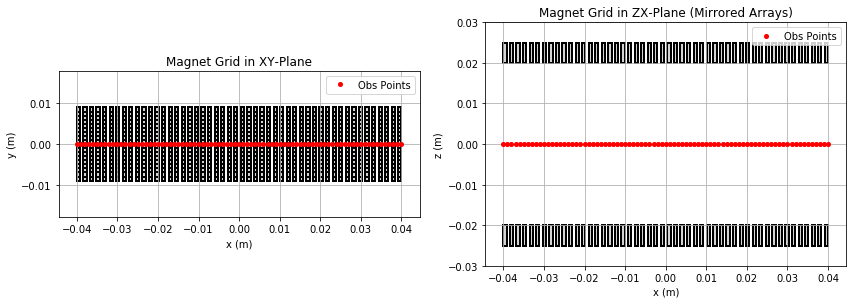

In [26]:
#------------------------------------------------------------------
# Dimensions and coordinates of the magnet grid, magnets and observation points. 
# The magnetic grid is constructed in the following way:
#   - Two mirror-symmetric magnet grids centered at (0,0,0): one above and one below the xy-plane.
#   - Each grid has N_X columns and N_Y rows of evenly spaced magnets.
#   - Each magnet is sized A_ONE x B_ONE x H; the grid spans A_TOTAL x B_TOTAL (height H).
#   - Magnet rows are offset a specific ZL for every row.
#   - Magnets are uniformly magnetized along z (magnetization MZ).
#------------------------------------------------------------------
A_TOTAL = 80e-3    # Width of the grid (x-dimension)   
A_ONE   = 0.8e-3     # Width of each magnet (x-dimension)   
N_X     = 50       # Number of magnets in the x-direction   
B_TOTAL = 18e-3    # Depth of the grid (y-dimension)   
B_ONE   = 1e-3     # Depth of each magnet (y-dimension)   
N_Y     = 18        # Number of magnets in the y-direction   
H       = 5e-3     # Height of each magnet (z-dimension)    
MZ      = 1.19     # Remanent magnetization of the magnets (z-direction)

# If ZL is constant use np.full(N_X, ZL) to create an array of length N_X with all elements equal to ZL.
# If ZL is a list of different values for each column, use ZL directly. 
# Copy this: ZL = np.array([15e-3, 15e-3, 15e-3, 15e-3, 15e-3, 15e-3, 15e-3, 15e-3, 15e-3, 15e-3])
ZL = np.full(N_X, 20e-3)

# Observation points (x,y,z) to evaluate the magnetic field.
X_VAL = np.arange(-40e-3, 41e-3, 1e-3)  # np.arange(-40e-3, 41e-3, 1e-3)
Y_VAL = 0.0  # np.arange(-9e-3, 10e-3, 1e-3)
Z_VAL = 0.0  # np.arange(-19e-3, 20e-3, 1e-3)

# Plot the magnetic grid and view the observation points.
plot_magnet_grid(A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y, H, ZL, X_VAL, Y_VAL, Z_VAL)

## Magnetic field functions

In [27]:
#------------------------------------------------------------------
# compute_centers: Computes the centers of the magnets.
#------------------------------------------------------------------
def compute_centers(a_total, a_one, n_x, b_total, b_one, n_y):
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    return x_centers, y_centers

#------------------------------------------------------------------
# dBz_numba: Inverse cube law for Bz field from a point dipole.
# x, y, z are the observation coordinates.
# xp, yp are the coordinates of the dipole.
# njit compiles the Python function to fast machine code using Numba’s just-in-time compiler, skipping Python’s slow interpreter.
# Fastmath = true allows the compiler to use faster, less strict floating-point optimizations, speeding up math operations where perfect IEEE precision is not critical.
# Fastmath is beneficial in numerical integration, where rounding errors average out, allowing faster computation with minimal accuracy loss.
#------------------------------------------------------------------
@njit(fastmath=True)
def dBz_numba(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    return sz / (np.sqrt(s) * s)

#------------------------------------------------------------------
# gauss2d: Performs 2D Gauss–Legendre quadrature over a rectangular area.
# a, b: lower and upper integration limits in the x-direction.
# c, d: lower and upper integration limits in the y-direction.
# func is evaluated at quadrature points in this rectangle.
# The result I is the numerical approximation of the double integral.
#------------------------------------------------------------------
@njit(fastmath=True)
def gauss2d(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    n = nodes.shape[0]
    I = 0.0
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    for i in range(n):
        for j in range(n):
            xi = half_b_a * nodes[i] + mid_b_a
            yj = half_d_c * nodes[j] + mid_d_c
            I += weights[i] * weights[j] * func(xi, yj, x_param, y_param, z_param)
    I *= 0.25 * (b - a) * (d - c)
    return I

#------------------------------------------------------------------
# Bsquare_strip: Calculates the magnetic field from a single finite uniformly magnetized strip.
# The strip represents one half of a full magnet, meaning it only accounts for the magnetic field contribution from one side.
# This is because a full magnet consists of two opposing poles, and this function integrates over only one of them.
# It integrates over a given x-interval [x_min, x_max] and over y-interval [y_min, y_max].
#------------------------------------------------------------------
@njit(fastmath=True)
def Bsquare_strip_numba(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = gauss2d(dBz_numba, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    C = 1.0 / (4.0 * np.pi)
    return C * Bz

#------------------------------------------------------------------
# Bz_one_magnet_numba: Computes the net z-field for one magnet by taking the difference of the two sides.
# This difference is mutplied by magnetisation of the magnet, which is assumed to be in the z-direction and the same for both magnets.
#------------------------------------------------------------------
@njit(fastmath=True)
def Bz_one_magnet_numba(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = Bsquare_strip_numba(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = Bsquare_strip_numba(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

#------------------------------------------------------------------
# Bz_two_magnet_numba: Computes the net field from two magnets.
# Mz is the magnetization of the magnets.
#------------------------------------------------------------------
@njit(fastmath=True)
def Bz_two_magnet_numba(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = Bz_one_magnet_numba(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = Bz_one_magnet_numba(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

#------------------------------------------------------------------
# compute_all_Bz_for_points: Computes Bz at multiple observation points by summing contributions from each magnet.
# Parameters:
#   x_obs, y_obs, z_obs : Arrays of observation coordinates (flattened).
#   n_x, n_y            : Number of magnets in x and y directions.
#   h                   : Height of each magnet.
#   zl                  : Array of vertical offsets (per magnet column).
#   mz                  : Magnetization parameter.
#   X_MINS, X_MAXS      : Arrays with magnet boundary limits in x.
#   Y_MINS, Y_MAXS      : Arrays with magnet boundary limits in y.
#   nodes, weights      : Gauss–Legendre nodes and weights for integration.
# Parallelized over observation points (using prange) for faster computation.
#------------------------------------------------------------------
@njit(parallel=True, fastmath=True)
def compute_all_Bz_for_points(x_obs, y_obs, z_obs, n_x, n_y, h, zl, mz, X_MINS, X_MAXS, Y_MINS, Y_MAXS, nodes, weights):
    N = x_obs.shape[0]
    result = np.empty(N, dtype=np.float64)
    for i in prange(N):
        total = 0.0
        for j in range(n_y):
            for k in range(n_x):
                total += Bz_two_magnet_numba(x_obs[i], y_obs[i], z_obs[i],
                                             X_MINS[k], X_MAXS[k],
                                             Y_MINS[j], Y_MAXS[j],
                                             h, zl[k], mz, nodes, weights)
        result[i] = total
    return result

#------------------------------------------------------------------
# run_field_calculation: Computes Bz field over observation points.
# order: Legendre polynomial order for integration accuracy.
# Precomputes magnet boundaries (X_MINS, X_MAXS, Y_MINS, Y_MAXS).
# Broadcasts X_VAL, Y_VAL, Z_VAL to 1D arrays for vectorized processing.
# Calls compute_all_Bz_for_points to sum contributions from each magnet.
# Returns field results and the varying observation coordinate array.
#------------------------------------------------------------------
def run_field_calculation(order):
    # Compute centers and integration bounds.
    XCENTERS, YCENTERS = compute_centers(A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y)
    X_MINS = XCENTERS - A_ONE/2.0
    X_MAXS = XCENTERS + A_ONE/2.0
    Y_MINS = YCENTERS - B_ONE/2.0
    Y_MAXS = YCENTERS + B_ONE/2.0

    # Get Gauss–Legendre nodes and weights for the given order.
    nodes, weights = lg.leggauss(order)
    
    # Broadcast observation points.
    x_arr, y_arr, z_arr = np.broadcast_arrays(np.atleast_1d(X_VAL),
                                              np.atleast_1d(Y_VAL),
                                              np.atleast_1d(Z_VAL))
    x_flat = x_arr.ravel()
    y_flat = y_arr.ravel()
    z_flat = z_arr.ravel()

    result_flat = compute_all_Bz_for_points(x_flat, y_flat, z_flat,
                                            N_X, N_Y, H, np.array(ZL), MZ,
                                            X_MINS, X_MAXS, Y_MINS, Y_MAXS,
                                            nodes, weights)
    result = result_flat.reshape(x_arr.shape)
    
    # Determine which coordinate is varying.
    if np.size(X_VAL) > 1:
        obs = np.array(X_VAL)
    elif np.size(Y_VAL) > 1:
        obs = np.array(Y_VAL)
    elif np.size(Z_VAL) > 1:
        obs = np.array(Z_VAL)
    else:
        obs = None
    return result, obs

#------------------------------------------------------------------
# adaptive_run_field_calculation: Automatically finds the optimal Legendre polynomial order.
# tol: Desired accuracy threshold; stops when field changes less than tol between orders.
# orders: List of Legendre orders to test, starting low and increasing.
# Steps:
# - Start with a low order.
# - Compute magnetic field for each order.
# - Compare with result from previous order.
# - If difference < tol, stop and return that result and order.
# - If not converged, use the last (highest) order.
# Returns final field, observation points, and chosen Legendre order.
#------------------------------------------------------------------
def adaptive_run_field_calculation(tol, orders=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]):
    prev_result = None
    for order in orders:
        result, obs = run_field_calculation(order)
        if prev_result is not None:
            diff = np.max(np.abs(result - prev_result))
            if diff < tol:
                return result, obs, order
        prev_result = result
    print("No convergence reached; using order", orders[-1])
    return result, obs, orders[-1]

## Magnetic gradient functions

In [18]:
#------------------------------------------------------------------
# derivative_1d_5pt: Computes the derivative of a 1D array using a 5-point stencil.
# The 5-point stencil strikes the best balance between accuracy, stability, and computational efficiency
# 'values' represents the field (e.g., Bz), and 'x' represents the observation coordinate,
# which can be along the x, y, or z axis depending on the varying observation direction.
# Steps:
# - If less than 5 points, use simple central difference formulas.
# - For larger arrays:
#   - Apply 4th-order forward difference at first two points.
#   - Use 5-point central difference for interior points for high accuracy.
#   - Apply 4th-order backward difference for the last two points.
# - Return the computed derivative array.
#------------------------------------------------------------------
@njit(fastmath=True)
def derivative_1d_5pt(values, x):
    n = values.shape[0]
    d = np.empty(n, dtype=values.dtype)
    if n < 5:
        # Fallback to simple central differences if not enough points.
        d[0] = (values[1] - values[0]) / (x[1] - x[0])
        for i in range(1, n - 1):
            d[i] = (values[i + 1] - values[i - 1]) / (x[i + 1] - x[i - 1])
        d[n - 1] = (values[n - 1] - values[n - 2]) / (x[n - 1] - x[n - 2])
        return d

    h = x[1] - x[0]
    # Forward difference (4th order) for the first two points.
    d[0] = (-25 * values[0] + 48 * values[1] - 36 * values[2] + 16 * values[3] - 3 * values[4]) / (12 * h)
    d[1] = (-3 * values[0] - 10 * values[1] + 18 * values[2] - 6 * values[3] + values[4]) / (12 * h)
    # 5-point central difference for interior points.
    for i in range(2, n - 2):
        d[i] = (values[i - 2] - 8 * values[i - 1] + 8 * values[i + 1] - values[i + 2]) / (12 * h)
    # Backward difference (4th order) for the last two points.
    d[n - 2] = (-values[n - 5] + 6 * values[n - 4] - 18 * values[n - 3] + 10 * values[n - 2] + 3 * values[n - 1]) / (12 * h)
    d[n - 1] = (3 * values[n - 5] - 16 * values[n - 4] + 36 * values[n - 3] - 48 * values[n - 2] + 25 * values[n - 1]) / (12 * h)
    return d

#------------------------------------------------------------------
# compute_derivative: Calculates magnetic field gradients using the 5-point stencil method.
# Calls adaptive_run_field_calculation() to compute the Bz field and observation points.
# The gradient is calculated along the axis defined by these reference points (x, y, or z).
# Accuracy depends on the number of reference points; more points improve precision.
# Not possible to compute the derivative if only one point is provided — at least two points are needed.
#------------------------------------------------------------------
def compute_derivative():
    result, obs, order = adaptive_run_field_calculation(TOL) # TOL is defined globally in the initialisation section
    if np.size(obs) < 2:
        raise ValueError("At least two observation points are required to compute the derivative.")
    gradBZ = derivative_1d_5pt(result, obs)
    return gradBZ, obs

## Calculations and plots

In [22]:
start = time.perf_counter()
result, obs, chosen_order = adaptive_run_field_calculation(tol=1e-4)
end = time.perf_counter()
runtime = end - start

print("Runtime (seconds):", runtime)
print("Chosen Legendre order:", chosen_order)
print("Computed field result:")
print(result)

Runtime (seconds): 0.01630630000727251
Chosen Legendre order: 4
Computed field result:
[0.03039489 0.03305301 0.03568081 0.03824872 0.04072972 0.04310045
 0.04534182 0.04743948 0.04938379 0.05116967 0.0527961  0.05426558
 0.05558346 0.05675726 0.05779608 0.05870995 0.05950946 0.06020526
 0.06080782 0.06132718 0.06177281 0.06215349 0.06247729 0.06275151
 0.06298275 0.06317688 0.06333912 0.06347407 0.06358576 0.0636777
 0.06375296 0.06381417 0.06386357 0.06390309 0.06393433 0.06395865
 0.06397713 0.06399064 0.06399984 0.06400517 0.06400692 0.06400517
 0.06399984 0.06399064 0.06397713 0.06395865 0.06393433 0.06390309
 0.06386357 0.06381417 0.06375296 0.0636777  0.06358576 0.06347407
 0.06333912 0.06317688 0.06298275 0.06275151 0.06247729 0.06215349
 0.06177281 0.06132718 0.06080782 0.06020526 0.05950946 0.05870995
 0.05779608 0.05675726 0.05558346 0.05426558 0.0527961  0.05116967
 0.04938379 0.04743948 0.04534182 0.04310045 0.04072972 0.03824872
 0.03568081 0.03305301 0.03039489]


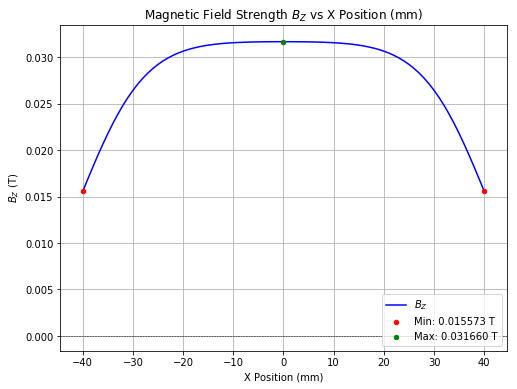

In [28]:
plot_Bz()

In [24]:
compute_derivative()

(array([ 2.66275426e+00,  2.64810992e+00,  2.60257052e+00,  2.52865274e+00,
         2.42940270e+00,  2.30883672e+00,  2.17151537e+00,  2.02221110e+00,
         1.86560341e+00,  1.70602906e+00,  1.54730219e+00,  1.39260731e+00,
         1.24445874e+00,  1.10471411e+00,  9.74626919e-01,  8.54923496e-01,
         7.45891524e-01,  6.47470248e-01,  5.59335397e-01,  4.80974627e-01,
         4.11751435e-01,  3.50957097e-01,  2.97851252e-01,  2.51692351e-01,
         2.11759473e-01,  1.77367083e-01,  1.47874164e-01,  1.22689066e-01,
         1.01271139e-01,  8.31300664e-02,  6.78236053e-02,  5.49542819e-02,
         4.41654520e-02,  3.51370204e-02,  2.75810279e-02,  2.12372403e-02,
         1.58688226e-02,  1.12581425e-02,  7.20271480e-03,  3.51128098e-03,
         2.89120579e-14, -3.51128098e-03, -7.20271480e-03, -1.12581425e-02,
        -1.58688226e-02, -2.12372403e-02, -2.75810279e-02, -3.51370204e-02,
        -4.41654520e-02, -5.49542819e-02, -6.78236053e-02, -8.31300664e-02,
        -1.0

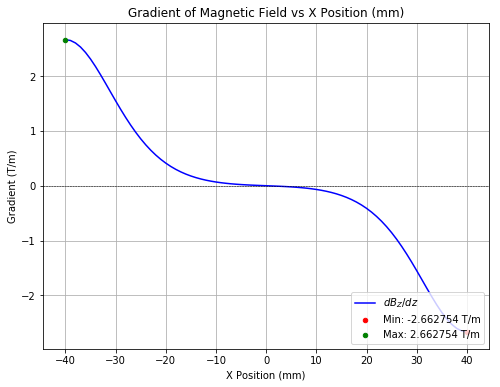

In [25]:
plot_derivative()

# 2. Old code for validating data

The rotating magnetic setup consists of two identical rotating magnets with a certain distance between them. This  setup experiences magnetic field gradients parallel to the magnets when simple block magnets are used. These gradients generate unwanted forces, preventing the system from operating purely based on magnetic torque. While weaker magnets and minimizing the distance between opposing magnets can reduce these gradients, small residual gradients will persist.    

Several approaches can be used to further lower the magnetic gradient, including modifying magnetization strength, adjusting geometric properties, or changing the distance between opposing magnets. Among these, adjusting the distance between the opposing magnets is the most practical option, as it can be easily achieved by using multiple small magnets and 3D-printed slots to control their spacing. In contrast, altering geometric or magnetic properties is more challenging due to the limited availability of magnet shapes and the complexity of manufacturing custom magnet geometries.    

This notebook calculates the optimal magnetic setup for a specified magnetic field strength with the smallest possible gradient parallel to the magnets. This ensures that the rotating magnetic setup operates purely with torque without creating any unwanted gradients parallel to the magnets.    

## Initializing functions

In [ ]:
import numpy as np
import math
from numpy import pi, sqrt
import scipy.integrate as integrate
from scipy.misc import derivative
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

epsilon=0.01 # Absolute error tolerance for numerial integration (dblquad)
DerP = 1e-5 # Step size (dx) for numerical differentiation (derivative)

## Magnetic field and gradient functions

In [ ]:
#------------------------------------------------------------------
# dBz: Inverse cube law for Bz field from a point dipole.
# x, y, z are the observation coordinates.
# xp, yp are the coordinates of the dipole.
#------------------------------------------------------------------
def dBz(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx**2 + sy**2 + sz**2
    dbz = sz / s**(3/2)
    return dbz

#------------------------------------------------------------------
# Bsquare_strip: Calculates the magnetic field from a single finite uniformly magnetized strip.
# The strip represents one half of a full magnet, meaning it only accounts for the magnetic field contribution from one side.
# This is because a full magnet consists of two opposing poles, and this function integrates over only one of them.
# It integrates over a given x-interval [x_min, x_max] and over y-interval [y_min, y_max].
#------------------------------------------------------------------
def Bsquare_strip(x, y, z, x_min, x_max, y_min, y_max):
    Bz, err = integrate.dblquad(
        dBz,
        y_min, y_max,                # yp limits: from y_min to y_max
        lambda yp: x_min,            # xp lower limit (independent of yp)
        lambda yp: x_max,            # xp upper limit
        args=(x, y, z),
        epsabs=epsilon
    )
    C = 1/(4*pi)
    return C * Bz

#------------------------------------------------------------------
# Bz_one_magnet: Computes the net z-field for one magnet by taking the difference of the two sides.
# This difference is mutplied by magnetisation of the magnet, which is assumed to be in the z-direction and the same for both magnets.
#------------------------------------------------------------------
def Bz_one_magnet(x, y, z, x_min, x_max, y_min, y_max, h, mz):
    Bf = Bsquare_strip(x, y, z - h/2, x_min, x_max, y_min, y_max)
    Bb = Bsquare_strip(x, y, z + h/2, x_min, x_max, y_min, y_max)
    return mz * (Bf - Bb)

#------------------------------------------------------------------
# Bz_two_magnets: Computes the net field from two magnets.
# Mz is the magnetization of the magnets.
#------------------------------------------------------------------
def Bz_two_magnet(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz):
    Bt = Bz_one_magnet(x, y, z - (zl + h/2), x_min, x_max, y_min, y_max, h, mz)
    Bb = Bz_one_magnet(x, y, z + (zl + h/2), x_min, x_max, y_min, y_max, h, mz)
    return Bt + Bb


#------------------------------------------------------------------
# Bz_from_array: Compute the net Bz field at (x,y,z) by summing contributions from each magnet in the grid.
# Parameters:
#   z_range : 1D array of z-values (in meters) at which to evaluate the field.
#   a_total : Total available extent in the x-direction.
#   a_one   : Width of each magnet in the x-direction.
#   n_x     : Number of magnets (columns) in the x-direction.
#   b_total : Total available extent in the y-direction.
#   b_one   : Depth of each magnet in the y-direction.
#   n_y     : Number of magnets (rows) in the y-direction.
#   h       : Height of each magnet (z-dimension).
#   zl      : List of z-offsets for each column (defines the magnet's bottom edge).
#   mz      : Magnetization parameter.
#------------------------------------------------------------------
def Bz_from_array(x, y, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz):
    if len(zl) != n_x:
        raise ValueError("Length of zl must equal the number of columns (n_x).")
    
    # Calculate centers in the x-direction (columns)
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    # Calculate centers in the y-direction (rows)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    
    Bz_total = 0.0
    # Loop over rows (y-direction)
    for j in range(n_y):
        y_center = y_centers[j]
        y_min = y_center - b_one/2.0
        y_max = y_center + b_one/2.0
        
        # Loop over columns (x-direction)
        for i in range(n_x):
            x_center = x_centers[i]
            x_min = x_center - a_one/2.0
            x_max = x_center + a_one/2.0
            
            # Use the column-specific z offset.
            z_offset = zl[i]
            
            # Sum the contribution from this magnet.
            Bz_total += Bz_two_magnet(x, y, z, x_min, x_max, y_min, y_max, h, z_offset, mz)
    
    return Bz_total

#------------------------------------------------------------------
# gradBz_from_array: Compute the magnetic gradient gradBz at (x,y,z) by numerical differentiation of Bz_from_array.
#------------------------------------------------------------------
def gradBz_from_array(x, y, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz):
    def fx(x_val):
        return Bz_from_array(x_val, y, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
    def fy(y_val):
        return Bz_from_array(x, y_val, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
    def fz(z_val):
        return Bz_from_array(x, y, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
    
    dBdx = derivative(fx, x, dx=DerP)
    dBdy = derivative(fy, y, dx=DerP)
    dBdz = derivative(fz, z, dx=DerP)
    
    return (dBdx, dBdy, dBdz)

## Plotting magnet array

In [ ]:
def plot_magnet_grid(a_total, a_one, n_x, b_total, b_one, n_y, h, zl):
    # --- Error Checks ---
    if len(zl) != n_x:
        raise ValueError("The length of the zl array must equal the number of columns (n_x).")
    if n_x * a_one > a_total + 1e-5:
        raise ValueError("n_x * a_one must be less than or equal to a_total to avoid overlapping magnets.")
    if n_y * b_one > b_total + 1e-5:
        raise ValueError("n_y * b_one must be less than or equal to b_total to avoid overlapping magnets.")

    # --- Compute Centers for the XY-Plane ---
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)

    # --- Create a Figure with Two Subplots (Side by Side) ---
    fig, (ax_xy, ax_zx) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    ax_xy.set_facecolor('white')
    ax_zx.set_facecolor('white')

    # --- Plot the Magnet Grid in the XY-Plane ---
    for row in range(n_y):
        for col in range(n_x):
            # Calculate the boundaries of each magnet.
            x_center = x_centers[col]
            y_center = y_centers[row]
            rect_x = x_center - a_one/2.0
            rect_y = y_center - b_one/2.0
            # Draw a light-grey rectangle with a black edge.
            magnet_rect = Rectangle((rect_x, rect_y), a_one, b_one,
                                      edgecolor='black', facecolor='lightgrey', lw=2)
            ax_xy.add_patch(magnet_rect)

    ax_xy.set_title('Magnet Grid in XY-Plane')
    ax_xy.set_xlabel('x (m)')
    ax_xy.set_ylabel('y (m)')
    # Set limits based on full extents.
    ax_xy.set_xlim(-a_total/1.8, a_total/1.8)
    z_upper = max(zl) + h
    z_lower = -(max(zl) + h)
    ax_xy.set_ylim(z_lower*2, z_upper*2)
    # Ensure equal scaling: 10 mm on x equals 10 mm on y.
    ax_xy.set_aspect('equal', adjustable='box')
    ax_xy.grid(True)

    # --- Plot the Magnet Grid in the ZX-Plane (with Mirrored Arrays) ---
    for col in range(n_x):
        x_center = x_centers[col]
        bottom_edge = zl[col]  # Magnet's bottom edge at zl.
        rect_x = x_center - a_one/2.0
        # Upper magnet spans from zl to zl+h.
        rect_z = bottom_edge
        magnet_rect_zx = Rectangle((rect_x, rect_z), a_one, h,
                                     edgecolor='black', facecolor='lightgrey', lw=2)
        ax_zx.add_patch(magnet_rect_zx)
        # Mirrored magnet spans from -(zl+h) to -zl.
        magnet_rect_zx_mirror = Rectangle((rect_x, -(bottom_edge + h)), a_one, h,
                                            edgecolor='black', facecolor='lightgrey', lw=2)
        ax_zx.add_patch(magnet_rect_zx_mirror)

    ax_zx.set_title('Magnet Grid in ZX-Plane (Mirrored Arrays)')
    ax_zx.set_xlabel('x (m)')
    ax_zx.set_ylabel('z (m)')
    ax_zx.set_xlim(-a_total/1.8, a_total/1.8)
    # Determine z-limits from the magnets: upper limit from the top of the upper magnets,
    # lower limit from the bottom of the mirrored magnets.
    ax_zx.set_ylim(z_lower*2, z_upper*2)
    # Ensure equal scaling: 10 mm on x equals 10 mm on z.
    ax_zx.set_aspect('equal', adjustable='box')
    ax_zx.grid(True)

    plt.tight_layout()
    plt.show()


## Plot magnetic field and gradient

In [ ]:
#------------------------------------------------------------------
# plot_Bz_and_grad_vs_z: Plots the magnetic field strength Bz and its gradient dBz/dz versus z.
#   Evaluation is done at (x,y) = (0,0).
#------------------------------------------------------------------
def plot_Bz_and_grad_vs_z(z_range, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz):
    # Set x and y to 0 for the evaluation.
    x_val = 0
    y_val = 0
    
    # Calculate magnetic field strength for each z.
    B_Z_values = np.array([
        Bz_from_array(x_val, y_val, zi, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
        for zi in z_range
    ])
    
    # Find extrema for Bz.
    min_index = np.argmin(B_Z_values)   # index of minimum value
    max_index_begin = 0                  # assume left edge is maximum
    max_index_end = -1                   # assume right edge is maximum

    min_value = B_Z_values[min_index]
    max_value_begin = B_Z_values[max_index_begin]
    max_value_end = B_Z_values[max_index_end]

    min_position = z_range[min_index] * 1e3      # convert to mm
    max_position_begin = z_range[max_index_begin] * 1e3
    max_position_end = z_range[max_index_end] * 1e3

    print("Magnetic Field Strength:")
    print(f"  Minimum value: {min_value:.6f} T at Z = {min_position:.2f} mm")
    print(f"  Maximum value (beginning): {max_value_begin:.6f} T at Z = {max_position_begin:.2f} mm")
    print(f"  Maximum value (end): {max_value_end:.6f} T at Z = {max_position_end:.2f} mm")
    
    # Create a single figure with two subplots (side by side)
    fig, (ax_field, ax_grad) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    fig.patch.set_facecolor('white')
    
    # Plot Bz vs. z on the left subplot.
    ax_field.plot(z_range * 1e3, B_Z_values, label="$B_Z$", color="blue")
    ax_field.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T", zorder=5)
    ax_field.scatter([max_position_begin], [max_value_begin], color="green", label=f"Max (beginning): {max_value_begin:.6f} T", zorder=5)
    ax_field.scatter([max_position_end], [max_value_end], color="orange", label=f"Max (end): {max_value_end:.6f} T", zorder=5)
    ax_field.set_xlabel("Z Position (mm)")
    ax_field.set_ylabel("$B_Z$ (T)")
    ax_field.set_title("Magnetic Field Strength $B_Z$ vs Z")
    ax_field.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_field.grid(True)
    ax_field.legend(loc='lower right')
    
    # Calculate magnetic field gradient for each z.
    # gradBz_from_array returns (dBdx, dBdy, dBdz); extract dBz/dz.
    gradB_tst = np.array([
        gradBz_from_array(x_val, y_val, zi, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
        for zi in z_range
    ])
    dB_Z_values = gradB_tst[:, 2]  # third component: dBz/dz
    
    # Find extrema for the gradient.
    min_index_grad = np.argmin(dB_Z_values)
    max_index_grad = np.argmax(dB_Z_values)
    
    min_grad_value = dB_Z_values[min_index_grad]
    max_grad_value = dB_Z_values[max_index_grad]
    
    min_grad_position = z_range[min_index_grad] * 1e3
    max_grad_position = z_range[max_index_grad] * 1e3
    
    print("Magnetic Field Gradient:")
    print(f"  Minimum gradient: {min_grad_value:.6f} T/m at Z = {min_grad_position:.2f} mm")
    print(f"  Maximum gradient: {max_grad_value:.6f} T/m at Z = {max_grad_position:.2f} mm")
    
    # Plot dBz/dz vs. z on the right subplot.
    ax_grad.plot(z_range * 1e3, dB_Z_values, label="$dB_Z/dZ$", color="blue")
    ax_grad.scatter([min_grad_position], [min_grad_value], color="red", label=f"Min: {min_grad_value:.6f} T/m", zorder=5)
    ax_grad.scatter([max_grad_position], [max_grad_value], color="green", label=f"Max: {max_grad_value:.6f} T/m", zorder=5)
    ax_grad.scatter([0], [0], color="black", marker='x', label="Zero Gradient", zorder=5)
    ax_grad.set_xlabel("Z Position (mm)")
    ax_grad.set_ylabel("$dB_Z/dZ$ (T/m)")
    ax_grad.set_title("Magnetic Field Gradient $dB_Z/dZ$ vs Z")
    ax_grad.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_grad.grid(True)
    ax_grad.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()


#------------------------------------------------------------------
# plot_Bz_and_grad_vs_x: Plots the magnetic field strength Bz and its gradient dBz/dx versus x.
# Evaluation is done at (y,z) = (0,0) for simplicity.
#------------------------------------------------------------------
def plot_Bz_and_grad_vs_x(x_range, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz):
    # Set y and z to 0 for the evaluation.
    y_val = 0
    z_val = 0

    # Calculate magnetic field strength for each x.
    B_values = np.array([
        Bz_from_array(xi, y_val, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
        for xi in x_range
    ])

    # Find extrema for Bz.
    max_index = np.argmax(B_values)
    min_index_begin = 0
    min_index_end = -1

    max_value = B_values[max_index]
    min_value_begin = B_values[min_index_begin]
    min_value_end = B_values[min_index_end]

    max_position = x_range[max_index] * 1e3       # convert to mm
    min_position_begin = x_range[min_index_begin] * 1e3
    min_position_end = x_range[min_index_end] * 1e3

    print("Magnetic Field Strength:")
    print(f"  Maximum value: {max_value:.6f} T at X = {max_position:.2f} mm")
    print(f"  Minimum value (left): {min_value_begin:.6f} T at X = {min_position_begin:.2f} mm")
    print(f"  Minimum value (right): {min_value_end:.6f} T at X = {min_position_end:.2f} mm")

    # Create a single figure with two subplots (side by side)
    fig, (ax_field, ax_grad) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    fig.patch.set_facecolor('white')
    
    # Plot Bz vs. x on the left subplot.
    ax_field.plot(x_range * 1e3, B_values, label="$B_Z$", color="blue")
    ax_field.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T", zorder=5)
    ax_field.scatter([min_position_begin], [min_value_begin], color="red", label=f"Min (left): {min_value_begin:.6f} T", zorder=5)
    ax_field.scatter([min_position_end], [min_value_end], color="orange", label=f"Min (right): {min_value_end:.6f} T", zorder=5)
    ax_field.set_xlabel("X Position (mm)")
    ax_field.set_ylabel("$B_Z$ (T)")
    ax_field.set_title("Magnetic Field Strength $B_Z$ vs X")
    ax_field.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_field.grid(True)
    ax_field.legend(loc='lower right')

    # Calculate magnetic field gradient for each x.
    # gradBz_from_array returns a tuple (dBdx, dBdy, dBdz); extract dBdx.
    gradB_tst = np.array([
        gradBz_from_array(xi, y_val, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
        for xi in x_range
    ])
    dB_Z_values = gradB_tst[:, 0]  # extract first component: dBz/dx

    # Find extrema for the gradient.
    min_index_grad = np.argmin(dB_Z_values)
    max_index_grad = np.argmax(dB_Z_values)

    min_grad_value = dB_Z_values[min_index_grad]
    max_grad_value = dB_Z_values[max_index_grad]

    min_grad_position = x_range[min_index_grad] * 1e3  # convert to mm
    max_grad_position = x_range[max_index_grad] * 1e3  # convert to mm

    print("Magnetic Field Gradient:")
    print(f"  Minimum gradient: {min_grad_value:.6f} T/m at X = {min_grad_position:.2f} mm")
    print(f"  Maximum gradient: {max_grad_value:.6f} T/m at X = {max_grad_position:.2f} mm")

    # Plot dBz/dx vs. x on the right subplot.
    ax_grad.plot(x_range * 1e3, dB_Z_values, label="$dB_X/dX$", color="blue")
    ax_grad.scatter([min_grad_position], [min_grad_value], color="red", label=f"Min: {min_grad_value:.6f} T/m", zorder=5)
    ax_grad.scatter([max_grad_position], [max_grad_value], color="green", label=f"Max: {max_grad_value:.6f} T/m", zorder=5)
    ax_grad.scatter([0], [0], color="black", marker='x', label="Zero Gradient", zorder=5)
    ax_grad.set_xlabel("X Position (mm)")
    ax_grad.set_ylabel("$dB_X/dX$ (T/m)")
    ax_grad.set_title("Magnetic Field Gradient $dB_X/dX$ (T/m) vs X")
    ax_grad.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_grad.grid(True)
    ax_grad.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

#------------------------------------------------------------------
# plot_Bz_and_grad_vs_y: Plots the magnetic field strength Bz and its gradient dBz/dy versus y.
# Evaluation is done at (x,z) = (0,0) for simplicity.
#------------------------------------------------------------------
def plot_Bz_and_grad_vs_y(y_range, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz):
    x_val = 0
    z_val = 0
    
    # Calculate magnetic field strength for each y
    B_Z_values = np.array([
        Bz_from_array(x_val, yi, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
        for yi in y_range
    ])
    
    # Find extrema
    min_index = np.argmin(B_Z_values)
    max_index_begin = 0
    max_index_end = -1

    min_value = B_Z_values[min_index]
    max_value_begin = B_Z_values[max_index_begin]
    max_value_end = B_Z_values[max_index_end]

    min_position = y_range[min_index] * 1e3
    max_position_begin = y_range[max_index_begin] * 1e3
    max_position_end = y_range[max_index_end] * 1e3

    print("Magnetic Field Strength along Y:")
    print(f"  Minimum value: {min_value:.6f} T at Y = {min_position:.2f} mm")
    print(f"  Maximum value (start): {max_value_begin:.6f} T at Y = {max_position_begin:.2f} mm")
    print(f"  Maximum value (end): {max_value_end:.6f} T at Y = {max_position_end:.2f} mm")
    
    # Create figure with two subplots
    fig, (ax_field, ax_grad) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    
    # Plot Bz vs. y
    ax_field.plot(y_range * 1e3, B_Z_values, color="blue", label="$B_Z$")
    ax_field.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T", zorder=5)
    ax_field.scatter([max_position_begin], [max_value_begin], color="green", label=f"Max start: {max_value_begin:.6f} T", zorder=5)
    ax_field.scatter([max_position_end], [max_value_end], color="orange", label=f"Max end: {max_value_end:.6f} T", zorder=5)
    ax_field.set_xlabel("Y Position (mm)")
    ax_field.set_ylabel("$B_Z$ (T)")
    ax_field.set_title("Magnetic Field Strength $B_Z$ vs Y")
    ax_field.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax_field.grid(True)
    ax_field.legend(loc='lower right')
    
    # Calculate gradient dBz/dy
    gradB_tst = np.array([
        gradBz_from_array(x_val, yi, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
        for yi in y_range
    ])
    dB_Z_values = gradB_tst[:, 1]  # gradient along y
    
    min_grad_index = np.argmin(dB_Z_values)
    max_grad_index = np.argmax(dB_Z_values)
    
    min_grad_value = dB_Z_values[min_grad_index]
    max_grad_value = dB_Z_values[max_grad_index]
    
    min_grad_pos = y_range[min_grad_index] * 1e3
    max_grad_pos = y_range[max_grad_index] * 1e3
    
    print("Magnetic Field Gradient along Y:")
    print(f"  Minimum gradient: {min_grad_value:.6f} T/m at Y = {min_grad_pos:.2f} mm")
    print(f"  Maximum gradient: {max_grad_value:.6f} T/m at Y = {max_grad_pos:.2f} mm")
    
    # Plot gradient
    ax_grad.plot(y_range * 1e3, dB_Z_values, color="blue", label="$dB_Z/dY$")
    ax_grad.scatter([min_grad_pos], [min_grad_value], color="red", label=f"Min: {min_grad_value:.6f} T/m", zorder=5)
    ax_grad.scatter([max_grad_pos], [max_grad_value], color="green", label=f"Max: {max_grad_value:.6f} T/m", zorder=5)
    ax_grad.scatter([0], [0], color="black", marker='x', label="Zero Gradient", zorder=5)
    ax_grad.set_xlabel("Y Position (mm)")
    ax_grad.set_ylabel("$dB_Z/dY$ (T/m)")
    ax_grad.set_title("Magnetic Field Gradient $dB_Z/dY$ vs Y")
    ax_grad.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax_grad.grid(True)
    ax_grad.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()


## Testing

In [ ]:
# --- Fabricated Parameters ---
a_total = 80e-3       # Total available extent in the x-direction
a_one   = 80e-3       # Width of each magnet in x
n_x     = 1        # Number of magnets (columns) in the x-direction

b_total = 18e-3       # Total available extent in the y-direction
b_one   = 9e-3        # Depth of each magnet in y
n_y     = 2           # Number of magnets (rows) in the y-direction

h       = 5e-3        # Height of each magnet (z-dimension)
zl      = [20e-3]  # Z-offset for each column (defines the magnet's bottom edge)
plot_magnet_grid(a_total, a_one, n_x, b_total, b_one, n_y, h, zl)

In [ ]:
# Speed test for Bz_from_array
x_range = np.arange(-40e-3, 41e-3, 1e-3)  # x from -40 mm to 40 mm in 1 mm steps
y_val = 0
z_val = 0
mz = 1.19
print(np.array([Bz_from_array(xi, y_val, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)for xi in x_range]))

In [ ]:
print(np.array([gradBz_from_array(xi, y_val, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)for xi in x_range])[:,0])

## Old graphs

In [ ]:
z_range = np.arange(-19e-3, 20e-3, 1e-3)  # from -19 mm to 20 mm in 1 mm steps
plot_Bz_and_grad_vs_z(z_range, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)

In [ ]:
x_range = np.arange(-40e-3, 41e-3, 1e-3)  # x from -40 mm to 40 mm in 1 mm steps
plot_Bz_and_grad_vs_x(x_range, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)

In [ ]:
y_range = np.arange(-9e-3, 9.5e-3, 0.5e-3)  # x from -40 mm to 40 mm in 1 mm steps
plot_Bz_and_grad_vs_y(y_range, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)

# Code graveyard

In [ ]:
#------------------------------------------------------------------
# dBz: Inverse cube law for Bz field from a point dipole.
# x, y, z are the observation coordinates.
# xp, yp are the coordinates of the dipole.
#------------------------------------------------------------------
def dBz(xp,yp,x,y,z):
    sx = x-xp
    sy = y-yp
    sz = z
    s = sx**2 + sy**2 + sz**2
    dbz = sz/s**(3/2)
    return dbz

#------------------------------------------------------------------
# Bsquare_strip: Calculates the magnetic field from a single finite uniformly magnetized strip.
# The strip represents one half of a full magnet, meaning it only accounts for the magnetic field contribution from one side.
# This is because a full magnet consists of two opposing poles, and this function integrates over only one of them.
# It integrates over a given x-interval [x_min, x_max] and over y from -b to b.
#------------------------------------------------------------------
def Bsquare_strip(x, y, z, x_min, x_max, b):
    Bz, err = integrate.dblquad(
        dBz,
        -b, b,                      # yp limits: -b to b
        lambda yp: x_min,           # xp lower limit (independent of yp)
        lambda yp: x_max,           # xp upper limit
        args=(x, y, z),
        epsabs=epsilon
    )
    C = 1/(4*pi)
    return C * Bz

#------------------------------------------------------------------
# Bz_one_magnet: Computes the net z-field for one magnet by taking the difference of the two sides.
# This difference is mutplied by magnetisation of the magnet, which is assumed to be in the z-direction and the same for both magnets.
#------------------------------------------------------------------
def Bz_one_magnet(x, y, z, x_min, x_max, b, h, mz):
    Bf = Bsquare_strip(x, y, z - h/2, x_min, x_max, b)
    Bb = Bsquare_strip(x, y, z + h/2, x_min, x_max, b)
    return mz * (Bf - Bb)

#------------------------------------------------------------------
# Bz_two_magnets: Computes the net field from two magnets.
#------------------------------------------------------------------
def Bz_two_magnet(x, y, z, x_min, x_max, b, h, zl, mz):
    Bt = Bz_one_magnet(x, y, z - (zl + h/2), x_min, x_max, b, h, mz)
    Bb = Bz_one_magnet(x, y, z + (zl + h/2), x_min, x_max, b, h, mz)
    return Bt + Bb

#------------------------------------------------------------------
# Bz_from_array: Compute the net Bz field at (x,y,z) by summing contributions from each magnet in the array.
# Each magnet is assumed to occupy the x-interval: [x_min, x_max] = [-a_total/2 + i*a_one,  -a_total/2 + (i+1)*a_one]
#------------------------------------------------------------------
def Bz_from_array(x, y, z, a_total, a_one, b_list, h, zl, mz):
    N = int(a_total / a_one)
    if len(b_list) != N:
        raise ValueError("Length of b_list must equal a_total / a_strip.")
    
    Bz_total = 0.0
    x_left = -a_total / 2.0
    for i in range(N):
        x_min = x_left + i * a_one
        x_max = x_min + a_one
        b_i = b_list[i]
        Bz_i = Bz_two_magnet(x, y, z, x_min, x_max, b_i, h, zl, mz)
        Bz_total += Bz_i
    return Bz_total

#------------------------------------------------------------------
# gradBz_from_array: Compute the magnetic gradient gradBz at (x,y,z) by numerical differentiation of Bz_from_array.
#------------------------------------------------------------------
def gradBz_from_array(x, y, z, a_total, a_one, b_list, h, zl, mz):
    def fx(x):
        return Bz_from_array(x, y, z, a_total, a_one, b_list, h, zl, mz)
    def fy(y):
        return Bz_from_array(x, y, z, a_total, a_one, b_list, h, zl, mz)
    def fz(z):
        return Bz_from_array(x, y, z, a_total, a_one, b_list, h, zl, mz)
    dBdx = derivative(fx, x, dx=DerP)
    dBdy = derivative(fy, y, dx=DerP)
    dBdz = derivative(fz, z, dx=DerP)
    return (dBdx,dBdy,dBdz)

In [ ]:
#------------------------------------------------------------------
# plot_magnet_array: Plots the magnet array geometry.
#------------------------------------------------------------------
def plot_magnet_array(a_total, a_one, b_list):
    # X positions for strip centers
    strip_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, len(b_list))

    # Create figure
    plt.figure(figsize=(8, 8), facecolor='white')
    
    # Loop through each strip and plot it
    for x, b in zip(strip_centers, b_list):
        plt.fill_between([x - a_one/2, x + a_one/2], -b, b, color='grey', alpha=0.7)
        plt.plot([x - a_one/2, x + a_one/2, x + a_one/2, x - a_one/2, x - a_one/2],
                 [-b, -b, b, b, -b], color='blue', linewidth=2)

    # Formatting the plot
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("Magnet Shape with Strips")
    plt.axis("square")
    plt.grid(True)

    # Set axis limits
    plt.xlim(-a_total/2*1.2, a_total/2*1.2)
    plt.ylim(-a_total/2*1.2, a_total/2*1.2)

    # Show plot
    plt.show()

In [ ]:
#------------------------------------------------------------------
# plot_Bz_and_grad_vs_z: Plots the magnetic field and gradient in the z-direction.
# The points that are plotted are determined by z_range.
# The user must define z_range themselves to give flexibility regarding the range of z-values.
# More z-values result in a smoother plot, but it will take longer to compute.
#------------------------------------------------------------------
def plot_Bz_and_grad_vs_z(z_range, a_total, a_one, b_list, h, zl, mz):
    # Set x and y to 0 for the evaluation.
    x_val = 0
    y_val = 0
    
    # Calculate magnetic field strength for each z.
    B_Z_values = np.array([Bz_from_array(x_val, y_val, zi, a_total, a_one, b_list, h, zl, mz) for zi in z_range])
    
    # Find minima and maxima for Bz.
    min_index = np.argmin(B_Z_values)   # index of minimum value
    max_index_begin = 0                  # assume left edge is maximum (if desired)
    max_index_end = -1                   # assume right edge is maximum
    # (Adjust these assumptions as needed.)
    
    min_value = B_Z_values[min_index]
    max_value_begin = B_Z_values[max_index_begin]
    max_value_end = B_Z_values[max_index_end]
    
    min_position = z_range[min_index] * 1e3      # convert to mm
    max_position_begin = z_range[max_index_begin] * 1e3
    max_position_end = z_range[max_index_end] * 1e3
    
    print(f"Magnetic Field Strength:")
    print(f"  Minimum value: {min_value:.6f} T at Z = {min_position:.2f} mm")
    print(f"  Maximum value (beginning): {max_value_begin:.6f} T at Z = {max_position_begin:.2f} mm")
    print(f"  Maximum value (end): {max_value_end:.6f} T at Z = {max_position_end:.2f} mm")
    
    # Plot Bz vs. z.
    plt.figure(figsize=(10, 8), facecolor='white')
    plt.plot(z_range * 1e3, B_Z_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T", zorder=5)
    plt.scatter([max_position_begin], [max_value_begin], color="green", label=f"Max (beginning): {max_value_begin:.6f} T", zorder=5)
    plt.scatter([max_position_end], [max_value_end], color="orange", label=f"Max (end): {max_value_end:.6f} T", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
     # Calculate magnetic field gradient for each z.
    gradB_tst = np.array([gradBz_from_array(x_val, y_val, zi, a_total, a_one, b_list, h, zl, mz) for zi in z_range])
    # Extract the third component (dBz/dz).
    dB_Z_values = gradB_tst[:, 2]
    
    # Find minima and maxima for the gradient.
    min_index_grad = np.argmin(dB_Z_values)
    max_index_grad = np.argmax(dB_Z_values)
    
    min_grad_value = dB_Z_values[min_index_grad]
    max_grad_value = dB_Z_values[max_index_grad]
    
    min_grad_position = z_range[min_index_grad] * 1e3
    max_grad_position = z_range[max_index_grad] * 1e3
    
    print(f"Magnetic Field Gradient:")
    print(f"  Minimum gradient: {min_grad_value:.6f} T/m at Z = {min_grad_position:.2f} mm")
    print(f"  Maximum gradient: {max_grad_value:.6f} T/m at Z = {max_grad_position:.2f} mm")
    
    # Plot the gradient vs. z.
    plt.figure(figsize=(10, 8), facecolor='white')
    plt.plot(z_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dZ$", color="blue")
    plt.scatter([min_grad_position], [min_grad_value], color="red", label=f"Min: {min_grad_value:.6f} T/m", zorder=5)
    plt.scatter([max_grad_position], [max_grad_value], color="green", label=f"Max: {max_grad_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dZ$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dZ$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

#------------------------------------------------------------------
# plot_Bz_and_grad_vs_x: Plots the magnetic field and gradient in the z-direction.
# The points that are plotted are determined by z_range.
# The user must define z_range themselves to give flexibility regarding the range of z-values.
# More z-values result in a smoother plot, but it will take longer to compute.
#------------------------------------------------------------------
def plot_Bz_and_grad_vs_x(x_range, a_total, a_one, b_list, h, zl, mz):
    # Set z and y to 0 for the evaluation.
    y_val = 0
    z_val = 0
    
    # Calculate magnetic field strength for each x
    B_values = np.array([Bz_from_array(xi, y_val, z_val, a_total, a_one, b_list, h, zl, mz) for xi in x_range])
    
    # Find extrema for Bz: assume maximum is in the middle, and minima at left and right edges.
    max_index = np.argmax(B_values)
    min_index_begin = 0
    min_index_end = -1
    
    max_value = B_values[max_index]
    min_value_begin = B_values[min_index_begin]
    min_value_end = B_values[min_index_end]
    
    max_position = x_range[max_index] * 1e3       # convert to mm
    min_position_begin = x_range[min_index_begin] * 1e3
    min_position_end = x_range[min_index_end] * 1e3
    
    # Print the extrema details for Bz
    print(f"Magnetic Field Strength:")
    print(f"  Maximum value: {max_value:.6f} T at X = {max_position:.2f} mm")
    print(f"  Minimum value (left): {min_value_begin:.6f} T at X = {min_position_begin:.2f} mm")
    print(f"  Minimum value (right): {min_value_end:.6f} T at X = {min_position_end:.2f} mm")
    
    # Plot Bz versus x
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8), facecolor='white')
    plt.plot(x_range * 1e3, B_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T", zorder=5)
    plt.scatter([min_position_begin], [min_value_begin], color="red", label=f"Min (left): {min_value_begin:.6f} T", zorder=5)
    plt.scatter([min_position_end], [min_value_end], color="orange", label=f"Min (right): {min_value_end:.6f} T", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
    # Calculate magnetic field gradient for each x using gradBz_two.
    # gradBz_two returns a tuple (dBdx, dBdy, dBdz); we extract the first component (dBz/dx).
    gradB_tst = np.array([gradBz_from_array(xi, y_val, z_val, a_total, a_one, b_list, h, zl, mz) for xi in x_range])
    dB_Z_values = gradB_tst[:, 0]

    # Find minimum and maximum
    min_index = np.argmin(dB_Z_values)  # Index of minimum value
    max_index = np.argmax(dB_Z_values)  # Index of maximum value

    # Values and positions
    min_value = dB_Z_values[min_index]
    max_value = dB_Z_values[max_index]
    min_position = x_range[min_index] * 1e3  # Convert to mm
    max_position = x_range[max_index] * 1e3  # Convert to mm

    # Print the extrema details
    print(f"Minimum value: {min_value:.6f} T/m at X = {min_position:.2f} mm")
    print(f"Maximum value: {max_value:.6f} T/m at X = {max_position:.2f} mm")

    # Plot the results
    plt.figure(figsize=(10, 8), facecolor='white')  # Increased figure size
    plt.plot(x_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dX$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T/m", zorder=5)
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dX$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dX$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# --- Fabricated Parameters ---
a_total = 80e-3       # Total available extent in the x-direction
a_one   = 20e-3       # Width of each magnet in x
n_x     = 4           # Number of magnets (columns) in the x-direction

b_total = 18e-3       # Total available extent in the y-direction
b_one   = 4.5e-3        # Depth of each magnet in y
n_y     = 4           # Number of magnets (rows) in the y-direction

h       = 5e-3        # Height of each magnet (z-dimension)
zl      = [20e-3, 20e-3, 20e-3, 20e-3]  # Z-offset for each column (defines the magnet's bottom edge)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_magnet_grid(a_total, a_one, n_x, b_total, b_one, n_y, h, zl):
    # --- Error Checks ---
    if len(zl) != n_x:
        raise ValueError("The length of the zl array must equal the number of columns (n_x).")
    if n_x * a_one > a_total:
        raise ValueError("n_x * a_one must be less than or equal to a_total to avoid overlapping magnets.")
    if n_y * b_one > b_total:
        raise ValueError("n_y * b_one must be less than or equal to b_total to avoid overlapping magnets.")

    # --- Compute Centers for the XY-Plane ---
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)

    # Define a common limit for both plots (ensuring identical axis dimensions).
    common_limit = a_total/1.8

    # --- Create a Single Figure with Two Subplots (Side by Side) ---
    fig, (ax_xy, ax_zx) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    ax_xy.set_facecolor('white')
    ax_zx.set_facecolor('white')

    # --- Plot the Magnet Grid in the XY-Plane ---
    for row in range(n_y):
        for col in range(n_x):
            # Calculate the boundaries of each magnet.
            x_center = x_centers[col]
            y_center = y_centers[row]
            rect_x = x_center - a_one/2.0
            rect_y = y_center - b_one/2.0
            # Draw a light-grey rectangle with a black edge.
            magnet_rect = Rectangle((rect_x, rect_y), a_one, b_one,
                                      edgecolor='black', facecolor='lightgrey', lw=2)
            ax_xy.add_patch(magnet_rect)

    ax_xy.set_title('Magnet Grid in XY-Plane')
    ax_xy.set_xlabel('x')
    ax_xy.set_ylabel('y')
    ax_xy.set_aspect('equal', 'box')
    ax_xy.grid(True)
    ax_xy.set_xlim(-common_limit, common_limit)
    ax_xy.set_ylim(-common_limit, common_limit)

    # --- Plot the Magnet Grid in the ZX-Plane (with Mirrored Arrays) ---
    # Draw the original (upper) magnet array.
    for col in range(n_x):
        x_center = x_centers[col]
        bottom_edge = zl[col]  # Magnet's bottom edge at zl.
        rect_x = x_center - a_one/2.0
        rect_z = bottom_edge   # Rectangle’s bottom edge is exactly at zl.
        magnet_rect_zx = Rectangle((rect_x, rect_z), a_one, h,
                                     edgecolor='black', facecolor='lightgrey', lw=2)
        ax_zx.add_patch(magnet_rect_zx)

    # Draw the mirrored (lower) magnet array.
    for col in range(n_x):
        x_center = x_centers[col]
        bottom_edge = zl[col]
        rect_x = x_center - a_one/2.0
        # Mirror the magnet: if the original spans from zl to zl+h,
        # the mirrored one spans from -(zl+h) to -zl.
        mirror_rect_z = -(bottom_edge + h)
        magnet_rect_zx_mirror = Rectangle((rect_x, mirror_rect_z), a_one, h,
                                            edgecolor='black', facecolor='lightgrey', lw=2)
        ax_zx.add_patch(magnet_rect_zx_mirror)

    ax_zx.set_title('Magnet Grid in ZX-Plane (Mirrored Arrays)')
    ax_zx.set_xlabel('x')
    ax_zx.set_ylabel('z')
    ax_zx.set_aspect('equal', 'box')
    ax_zx.grid(True)
    ax_zx.set_xlim(-common_limit, common_limit)
    ax_zx.set_ylim(-common_limit, common_limit)

    plt.tight_layout()
    plt.show()
plot_magnet_grid(a_total, a_one, n_x, b_total, b_one, n_y, h, zl)


In [ ]:
#------------------------------------------------------------------
# dBz: Inverse cube law for Bz field from a point dipole.
# x, y, z are the observation coordinates.
# xp, yp are the coordinates of the dipole.
#------------------------------------------------------------------
def dBz(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx**2 + sy**2 + sz**2
    dbz = sz / s**(3/2)
    return dbz

#------------------------------------------------------------------
# Bsquare_strip: Calculates the magnetic field from a single finite uniformly magnetized strip.
# The strip represents one half of a full magnet, meaning it only accounts for the magnetic field contribution from one side.
# This is because a full magnet consists of two opposing poles, and this function integrates over only one of them.
# It integrates over a given x-interval [x_min, x_max] and over y-interval [y_min, y_max].
#------------------------------------------------------------------
def Bsquare_strip(x, y, z, x_min, x_max, y_min, y_max):
    Bz, err = integrate.dblquad(
        dBz,
        y_min, y_max,                # yp limits: from y_min to y_max
        lambda yp: x_min,            # xp lower limit (independent of yp)
        lambda yp: x_max,            # xp upper limit
        args=(x, y, z),
        epsabs=epsilon
    )
    C = 1/(4*pi)
    return C * Bz

#------------------------------------------------------------------
# Bz_one_magnet: Computes the net z-field for one magnet by taking the difference of the two sides.
# This difference is mutplied by magnetisation of the magnet, which is assumed to be in the z-direction and the same for both magnets.
#------------------------------------------------------------------
def Bz_one_magnet(x, y, z, x_min, x_max, y_min, y_max, h, mz):
    Bf = Bsquare_strip(x, y, z - h/2, x_min, x_max, y_min, y_max)
    Bb = Bsquare_strip(x, y, z + h/2, x_min, x_max, y_min, y_max)
    return mz * (Bf - Bb)

#------------------------------------------------------------------
# Bz_two_magnets: Computes the net field from two magnets.
#------------------------------------------------------------------
def Bz_two_magnet(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz):
    Bt = Bz_one_magnet(x, y, z - (zl + h/2), x_min, x_max, y_min, y_max, h, mz)
    Bb = Bz_one_magnet(x, y, z + (zl + h/2), x_min, x_max, y_min, y_max, h, mz)
    return Bt + Bb


#------------------------------------------------------------------
# Bz_from_array: Compute the net Bz field at (x,y,z) by summing contributions from each magnet in the grid.
#------------------------------------------------------------------
def Bz_from_array(x, y, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz):
    if len(zl) != n_x:
        raise ValueError("Length of zl must equal the number of columns (n_x).")
    
    # Calculate centers in the x-direction (columns)
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    # Calculate centers in the y-direction (rows)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    
    Bz_total = 0.0
    # Loop over rows (y-direction)
    for j in range(n_y):
        y_center = y_centers[j]
        y_min = y_center - b_one/2.0
        y_max = y_center + b_one/2.0
        
        # Loop over columns (x-direction)
        for i in range(n_x):
            x_center = x_centers[i]
            x_min = x_center - a_one/2.0
            x_max = x_center + a_one/2.0
            
            # Use the column-specific z offset.
            z_offset = zl[i]
            
            # Sum the contribution from this magnet.
            Bz_total += Bz_two_magnet(x, y, z, x_min, x_max, y_min, y_max, h, z_offset, mz)
    
    return Bz_total

#------------------------------------------------------------------
# gradBz_from_array: Compute the magnetic gradient gradBz at (x,y,z) by numerical differentiation of Bz_from_array.
#------------------------------------------------------------------
def gradBz_from_array(x, y, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz):
    def fx(x_val):
        return Bz_from_array(x_val, y, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
    def fy(y_val):
        return Bz_from_array(x, y_val, z, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
    def fz(z_val):
        return Bz_from_array(x, y, z_val, a_total, a_one, n_x, b_total, b_one, n_y, h, zl, mz)
    
    dBdx = derivative(fx, x, dx=DerP)
    dBdy = derivative(fy, y, dx=DerP)
    dBdz = derivative(fz, z, dx=DerP)
    
    return (dBdx, dBdy, dBdz)

In [ ]:
#------------------------------------------------------------------
# plot_Bz_and_grad_vs_z: Plots the magnetic field and gradient in the z-direction.
# The points that are plotted are determined by z_range.
# The user must define z_range themselves to give flexibility regarding the range of z-values.
# More z-values result in a smoother plot, but it will take longer to compute.
#------------------------------------------------------------------
def plot_Bz_and_grad_vs_z(z_range, a_total, a_one, b_list, h, zl, mz):
    # Set x and y to 0 for the evaluation.
    x_val = 0
    y_val = 0
    
    # Calculate magnetic field strength for each z.
    B_Z_values = np.array([Bz_from_array(x_val, y_val, zi, a_total, a_one, b_list, h, zl, mz) for zi in z_range])
    
    # Find minima and maxima for Bz.
    min_index = np.argmin(B_Z_values)   # index of minimum value
    max_index_begin = 0                  # assume left edge is maximum (if desired)
    max_index_end = -1                   # assume right edge is maximum
    # (Adjust these assumptions as needed.)
    
    min_value = B_Z_values[min_index]
    max_value_begin = B_Z_values[max_index_begin]
    max_value_end = B_Z_values[max_index_end]
    
    min_position = z_range[min_index] * 1e3      # convert to mm
    max_position_begin = z_range[max_index_begin] * 1e3
    max_position_end = z_range[max_index_end] * 1e3
    
    print(f"Magnetic Field Strength:")
    print(f"  Minimum value: {min_value:.6f} T at Z = {min_position:.2f} mm")
    print(f"  Maximum value (beginning): {max_value_begin:.6f} T at Z = {max_position_begin:.2f} mm")
    print(f"  Maximum value (end): {max_value_end:.6f} T at Z = {max_position_end:.2f} mm")
    
    # Plot Bz vs. z.
    plt.figure(figsize=(10, 8), facecolor='white')
    plt.plot(z_range * 1e3, B_Z_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T", zorder=5)
    plt.scatter([max_position_begin], [max_value_begin], color="green", label=f"Max (beginning): {max_value_begin:.6f} T", zorder=5)
    plt.scatter([max_position_end], [max_value_end], color="orange", label=f"Max (end): {max_value_end:.6f} T", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
     # Calculate magnetic field gradient for each z.
    gradB_tst = np.array([gradBz_from_array(x_val, y_val, zi, a_total, a_one, b_list, h, zl, mz) for zi in z_range])
    # Extract the third component (dBz/dz).
    dB_Z_values = gradB_tst[:, 2]
    
    # Find minima and maxima for the gradient.
    min_index_grad = np.argmin(dB_Z_values)
    max_index_grad = np.argmax(dB_Z_values)
    
    min_grad_value = dB_Z_values[min_index_grad]
    max_grad_value = dB_Z_values[max_index_grad]
    
    min_grad_position = z_range[min_index_grad] * 1e3
    max_grad_position = z_range[max_index_grad] * 1e3
    
    print(f"Magnetic Field Gradient:")
    print(f"  Minimum gradient: {min_grad_value:.6f} T/m at Z = {min_grad_position:.2f} mm")
    print(f"  Maximum gradient: {max_grad_value:.6f} T/m at Z = {max_grad_position:.2f} mm")
    
    # Plot the gradient vs. z.
    plt.figure(figsize=(10, 8), facecolor='white')
    plt.plot(z_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dZ$", color="blue")
    plt.scatter([min_grad_position], [min_grad_value], color="red", label=f"Min: {min_grad_value:.6f} T/m", zorder=5)
    plt.scatter([max_grad_position], [max_grad_value], color="green", label=f"Max: {max_grad_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dZ$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dZ$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

#------------------------------------------------------------------
# plot_Bz_and_grad_vs_x: Plots the magnetic field and gradient in the z-direction.
# The points that are plotted are determined by z_range.
# The user must define z_range themselves to give flexibility regarding the range of z-values.
# More z-values result in a smoother plot, but it will take longer to compute.
#------------------------------------------------------------------
def plot_Bz_and_grad_vs_x(x_range, a_total, a_one, b_list, h, zl, mz):
    # Set z and y to 0 for the evaluation.
    y_val = 0
    z_val = 0
    
    # Calculate magnetic field strength for each x
    B_values = np.array([Bz_from_array(xi, y_val, z_val, a_total, a_one, b_list, h, zl, mz) for xi in x_range])
    
    # Find extrema for Bz: assume maximum is in the middle, and minima at left and right edges.
    max_index = np.argmax(B_values)
    min_index_begin = 0
    min_index_end = -1
    
    max_value = B_values[max_index]
    min_value_begin = B_values[min_index_begin]
    min_value_end = B_values[min_index_end]
    
    max_position = x_range[max_index] * 1e3       # convert to mm
    min_position_begin = x_range[min_index_begin] * 1e3
    min_position_end = x_range[min_index_end] * 1e3
    
    # Print the extrema details for Bz
    print(f"Magnetic Field Strength:")
    print(f"  Maximum value: {max_value:.6f} T at X = {max_position:.2f} mm")
    print(f"  Minimum value (left): {min_value_begin:.6f} T at X = {min_position_begin:.2f} mm")
    print(f"  Minimum value (right): {min_value_end:.6f} T at X = {min_position_end:.2f} mm")
    
    # Plot Bz versus x
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8), facecolor='white')
    plt.plot(x_range * 1e3, B_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T", zorder=5)
    plt.scatter([min_position_begin], [min_value_begin], color="red", label=f"Min (left): {min_value_begin:.6f} T", zorder=5)
    plt.scatter([min_position_end], [min_value_end], color="orange", label=f"Min (right): {min_value_end:.6f} T", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
    # Calculate magnetic field gradient for each x using gradBz_two.
    # gradBz_two returns a tuple (dBdx, dBdy, dBdz); we extract the first component (dBz/dx).
    gradB_tst = np.array([gradBz_from_array(xi, y_val, z_val, a_total, a_one, b_list, h, zl, mz) for xi in x_range])
    dB_Z_values = gradB_tst[:, 0]

    # Find minimum and maximum
    min_index = np.argmin(dB_Z_values)  # Index of minimum value
    max_index = np.argmax(dB_Z_values)  # Index of maximum value

    # Values and positions
    min_value = dB_Z_values[min_index]
    max_value = dB_Z_values[max_index]
    min_position = x_range[min_index] * 1e3  # Convert to mm
    max_position = x_range[max_index] * 1e3  # Convert to mm

    # Print the extrema details
    print(f"Minimum value: {min_value:.6f} T/m at X = {min_position:.2f} mm")
    print(f"Maximum value: {max_value:.6f} T/m at X = {max_position:.2f} mm")

    # Plot the results
    plt.figure(figsize=(10, 8), facecolor='white')  # Increased figure size
    plt.plot(x_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dX$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T/m", zorder=5)
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dX$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dX$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def compute_centers(a_total, a_one, n_x, b_total, b_one, n_y):
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    return x_centers, y_centers

@njit(fastmath=True)
def dBz_numba(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    # Replace s**1.5 with math.sqrt(s)*s for speed
    return sz / (math.sqrt(s) * s)

@njit(fastmath=True)
def gauss2d(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    n = nodes.shape[0]
    I = 0.0
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    for i in range(n):
        for j in range(n):
            xi = half_b_a * nodes[i] + mid_b_a
            yj = half_d_c * nodes[j] + mid_d_c
            I += weights[i] * weights[j] * func(xi, yj, x_param, y_param, z_param)
    I *= 0.25 * (b - a) * (d - c)
    return I

@njit(fastmath=True)
def Bsquare_strip_numba(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = gauss2d(dBz_numba, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    C = 1.0 / (4.0 * math.pi)
    return C * Bz

@njit(fastmath=True)
def Bz_one_magnet_numba(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = Bsquare_strip_numba(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = Bsquare_strip_numba(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

@njit(fastmath=True)
def Bz_two_magnet_numba(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = Bz_one_magnet_numba(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = Bz_one_magnet_numba(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

@njit(fastmath=True)
def Bz_from_array_numba(x, y, z, n_x, n_y, h, zl, mz,
                         X_MINS, X_MAXS, Y_MINS, Y_MAXS, nodes, weights):
    total = 0.0
    for j in range(n_y):
        for i in range(n_x):
            total += Bz_two_magnet_numba(x, y, z,
                                         X_MINS[i], X_MAXS[i],
                                         Y_MINS[j], Y_MAXS[j],
                                         h, zl[i], mz, nodes, weights)
    return total

@njit(parallel=True, fastmath=True)
def compute_all_Bz_for_points(x_obs, y_obs, z_obs, n_x, n_y, h, zl, mz,
                              X_MINS, X_MAXS, Y_MINS, Y_MAXS, nodes, weights):
    N = x_obs.shape[0]
    result = np.empty(N, dtype=np.float64)
    for i in prange(N):
        result[i] = Bz_from_array_numba(x_obs[i], y_obs[i], z_obs[i],
                                        n_x, n_y, h, zl, mz,
                                        X_MINS, X_MAXS, Y_MINS, Y_MAXS, nodes, weights)
    return result

def run_field_calculation():
    # Compute centers and integration bounds
    XCENTERS, YCENTERS = compute_centers(A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y)
    X_MINS = XCENTERS - A_ONE/2.0
    X_MAXS = XCENTERS + A_ONE/2.0
    Y_MINS = YCENTERS - B_ONE/2.0
    Y_MAXS = YCENTERS + B_ONE/2.0

    order = 20  # Order of the Legendre polynomial
    nodes, weights = lg.leggauss(order)

    # Broadcast observation points: convert each input to at least 1D arrays
    x_arr, y_arr, z_arr = np.broadcast_arrays(np.atleast_1d(X_VAL),
                                              np.atleast_1d(Y_VAL),
                                              np.atleast_1d(Z_VAL))
    # Flatten arrays for parallel computation.
    x_flat = x_arr.ravel()
    y_flat = y_arr.ravel()
    z_flat = z_arr.ravel()

    result_flat = compute_all_Bz_for_points(x_flat, y_flat, z_flat,
                                            N_X, N_Y, H, np.array(ZL), MZ,
                                            X_MINS, X_MAXS, Y_MINS, Y_MAXS,
                                            nodes, weights)

    # Reshape the result back to the observation shape.
    result = result_flat.reshape(x_arr.shape)
    
    # Determine which coordinate is varying (the one that was set as an array)
    if np.size(X_VAL) > 1:
        obs = np.array(X_VAL)
    elif np.size(Y_VAL) > 1:
        obs = np.array(Y_VAL)
    elif np.size(Z_VAL) > 1:
        obs = np.array(Z_VAL)
    else:
        obs = None
    return result, obs

In [ ]:
@njit(fastmath=True)
def derivative_1d_5pt(values, x):
    """
    Compute the numerical derivative of a 1D array 'values' with respect to 'x'
    using a 5-point stencil for interior points and appropriate formulas at the boundaries.
    Assumes that x is uniformly spaced.
    """
    n = values.shape[0]
    d = np.empty(n, dtype=values.dtype)
    if n < 5:
        # Fallback to simple central differences if not enough points.
        d[0] = (values[1] - values[0]) / (x[1] - x[0])
        for i in range(1, n - 1):
            d[i] = (values[i + 1] - values[i - 1]) / (x[i + 1] - x[i - 1])
        d[n - 1] = (values[n - 1] - values[n - 2]) / (x[n - 1] - x[n - 2])
        return d

    h = x[1] - x[0]
    # Forward difference (4th order) for the first two points.
    d[0] = (-25 * values[0] + 48 * values[1] - 36 * values[2] + 16 * values[3] - 3 * values[4]) / (12 * h)
    d[1] = (-3 * values[0] - 10 * values[1] + 18 * values[2] - 6 * values[3] + values[4]) / (12 * h)
    # 5-point central difference for interior points.
    for i in range(2, n - 2):
        d[i] = (values[i - 2] - 8 * values[i - 1] + 8 * values[i + 1] - values[i + 2]) / (12 * h)
    # Backward difference (4th order) for the last two points.
    d[n - 2] = (-values[n - 5] + 6 * values[n - 4] - 18 * values[n - 3] + 10 * values[n - 2] + 3 * values[n - 1]) / (12 * h)
    d[n - 1] = (3 * values[n - 5] - 16 * values[n - 4] + 36 * values[n - 3] - 48 * values[n - 2] + 25 * values[n - 1]) / (12 * h)
    return d

def compute_derivative():
    """
    Calls run_field_calculation() to obtain the computed Bz field and observation coordinate,
    then computes the derivative (using the 5-point stencil) and prints the resulting gradient.
    
    Returns:
        dBZ : 1D ndarray
            The computed derivative of the Bz field with respect to the varying coordinate.
    """
    # run_field_calculation() is assumed to return a tuple: (BZ_field, obs_array)
    result, obs = run_field_calculation()
    gradBZ = derivative_1d_5pt(result, obs)
    return gradBZ